# Exploratary Data Analysis (EDA)
Main goals for this EDA are:

- **Handling Missing Values:** Identify and address missing data to ensure a complete and accurate dataset.
- **Feature Selection:** Conduct a preliminary assessment to determine the most relevant features for analysis.
- **Problem Framing:** Clearly define and understand the problem to guide the analysis direction.
- **Pattern Discovery:** Uncover trends, patterns, and distributions within the data to gain initial insights.
- **Hypothesis Formulation:** Develop hypotheses based on observed data patterns to guide further analysis.
- **Assumption Checking:** Validate assumptions that are critical to the analysis and modeling process.
- **Outlier Detection:** Detect and manage outliers to prevent them from skewing the analysis results.
- **Relationship Exploration:** Investigate correlations and relationships between different variables in the dataset.

In [1]:
# import libraries
import os
import sys
import matplotlib as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew

# import custom libraries
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from app.config import SCHEMA
from app.libs import data_utils, eda_tools
from app import build_features

In [2]:
# read data
atp_df = data_utils.read_data(parent_dir + '/data/raw/atp')
wta_df = data_utils.read_data(parent_dir + '/data/raw/wta')

{"time": "2024-07-04T19:03:38Z", "level": "INFO", "log": "Reading all files in tennis-predictor\\venv/data/raw/atp..."}
{"time": "2024-07-04T19:03:40Z", "level": "INFO", "log": "Shape of the dataset: (36363, 54)"}
{"time": "2024-07-04T19:03:41Z", "level": "INFO", "log": "Reading all files in tennis-predictor\\venv/data/raw/wta..."}
{"time": "2024-07-04T19:03:42Z", "level": "INFO", "log": "Shape of the dataset: (7328, 38)"}


In [3]:
atp_df.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1',
       'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
       'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL',
       'SBW', 'SBL', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts',
       'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL',
       'AvgW', 'AvgL'],
      dtype='object')

In [4]:
wta_df.columns

Index(['wta', 'location', 'tournament', 'date', 'tier', 'court', 'surface',
       'round', 'best_of', 'winner', 'loser', 'wrank', 'lrank', 'wpts', 'lpts',
       'w1', 'l1', 'w2', 'l2', 'w3', 'l3', 'wsets', 'lsets', 'comment',
       'b365w', 'b365l', 'cbw', 'cbl', 'exw', 'exl', 'psw', 'psl', 'ubw',
       'ubl', 'lbw', 'lbl', 'sjw', 'sjl'],
      dtype='object')

### Select relevant columns and handle missing values

Relevant variables for this model are:
 - date    - match's date
 - winner  - player's name
 - loser   - player's name
 - wrank   - winner's ranking
 - lrank   - loser's ranking
 - b365w   - odd given for the winner by B365
 - b365l   - odd given for the loser by B365
 - surface - type of court

The following columns gives us the final score, which is not usefull for the outcome predictive model.
 -  w1 - 1st set winning score
 -  l1 - 1st set losing score
 -  w2 - 2nd set winning score
 -  l2 - 2nd set losing score
 -  w3 - 3rd set winning score   
 -  l3 - 3rd set winning score       

Details on the tournament were also disregarded.

Ordering the df by Date allows me to calculate the head-to-head (records between two individual players).

In [5]:
# Rename cols
atp_df.rename(columns=lambda x: x.lower(), inplace=True)

# Drop matches that aren't completed
atp_df = atp_df[atp_df['comment'] == "Completed"]

# Correct typos: Replace occurrences of '..' with '.0'
wta_df['b365l'] = wta_df['b365l'].apply(lambda x: str(x).replace('..', '.0') if isinstance(x, str) and '..' in x else x)

# Select relevant columns
atp_df = atp_df[SCHEMA['raw'].keys()]
wta_df = wta_df[SCHEMA['raw'].keys()]

# Format data according to data schemas toml file
atp_df = data_utils.format_data(atp_df, SCHEMA['raw'])
wta_df = data_utils.format_data(wta_df, SCHEMA['raw'])

# Concat datasets
df = pd.concat([atp_df, wta_df])
print('(rows, columns): ',df.shape,'\n')

eda_tools.check_missing_data(df)

# Drop rows with any missing values
all_matches = len(df)
df = df.dropna()
matches = len(df)
print(f'This way of dealing with missing values results in a lost of {all_matches-matches} events ({round((all_matches-matches)/all_matches*100,2)}%).\n\n')

# display data info
print(df.info())
df.head(3)

{"time": "2024-07-04T19:03:43Z", "level": "INFO", "log": "Data formatted according to the imported schema..."}
{"time": "2024-07-04T19:03:44Z", "level": "INFO", "log": "Data formatted according to the imported schema..."}
(rows, columns):  (42312, 8) 

Missing Data Percentage List
wrank - 0.08%
lrank - 0.24%
b365w - 6.4%
b365l - 6.37%
This way of dealing with missing values results in a lost of 2815 events (6.65%).


<class 'pandas.core.frame.DataFrame'>
Index: 39497 entries, 1371 to 7327
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     39497 non-null  datetime64[ns]
 1   winner   39497 non-null  string        
 2   loser    39497 non-null  string        
 3   wrank    39497 non-null  Int64         
 4   lrank    39497 non-null  Int64         
 5   b365w    39497 non-null  float64       
 6   b365l    39497 non-null  float64       
 7   surface  39497 non-null  string        
dtypes: Int64(2), dateti

,date,winner,loser,wrank,lrank,b365w,b365l,surface
1371,2002-06-10,Johansson T.,Pretzsch A.,7,133,1.100,6.500,Grass
1372,2002-06-10,Kafelnikov Y.,Bjorkman J.,6,56,1.444,2.625,Grass
1374,2002-06-10,Koubek S.,Moya C.,41,20,2.625,1.444,Grass


### Frame the problem
The mission of this project is to recommend bets where the accuracy level exceeds the level of accuracy calculated for each betting odd, shown in the plot below. This accuracy level is calculated based on the possible gains or losses, representing the percentage of correct predictions needed to break even or make a profit in the long run.

 ```python
gains > losses
(betting_odd - 1) * accuracy > -1 * (1 - accuracy)
accuracy > 1 / betting_odd
```

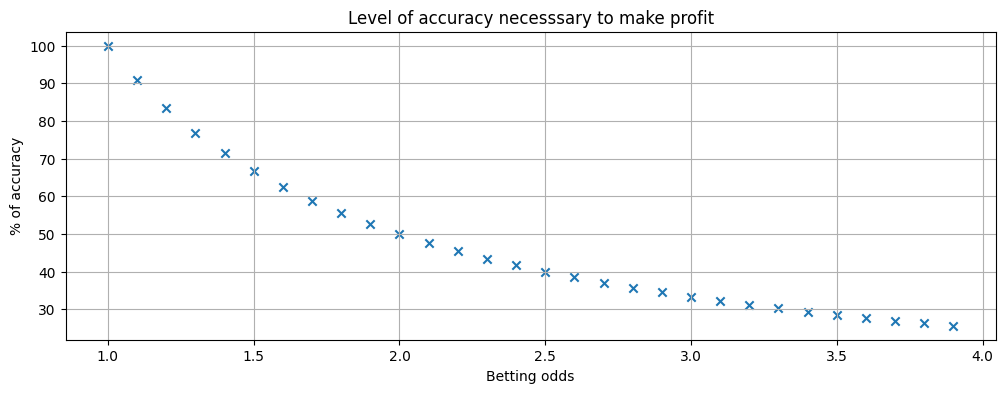

In [6]:
# plot between minimum value and 75th percentil of B365L
min_odd = df[['b365w','b365l']].min().min()
max_odd = df.describe().loc["75%", "b365l"]
odds = np.arange(min_odd, max_odd, 0.1)

# get accuracies
accuracies=[]
for betting_odd in odds:
    accuracy = 100 / betting_odd
    accuracies.append(accuracy)
plt.figure(figsize=(12,4))
plt.title('Level of accuracy necesssary to make profit')
plt.xlabel('Betting odds')
plt.ylabel('% of accuracy')
plt.scatter(odds, accuracies, marker='x')
plt.grid(True)
plt.show()

### Target
To maximize profits, we want to predict the probability of P1 being the winner ( ```P(P1wins)``` ). Then, this prediction is compared with the calculated accuracy level for each for that odd, following the logic below:
 ```python
if P(P1wins) > Accuracy(odd_p1):
    Recommend betting on P1
elif 1 - P(P1wins) > Accuracy(odd_p2):
    Recommend betting on P2
else:
    No recommendation
```

To apply this logic, we'll build a regression model to determine  ```P(P1wins)``` , which will be the target.

```P(P1wins)```  can be estimated as   ``` P(P1wins) = 1 / odd_p1 ```  (Target 1) or  ```P(P1wins) = odd_p2 / ( odd_p1 + odd_p2 )```  (Target 2).
So, we look at both distributions and some statistics.

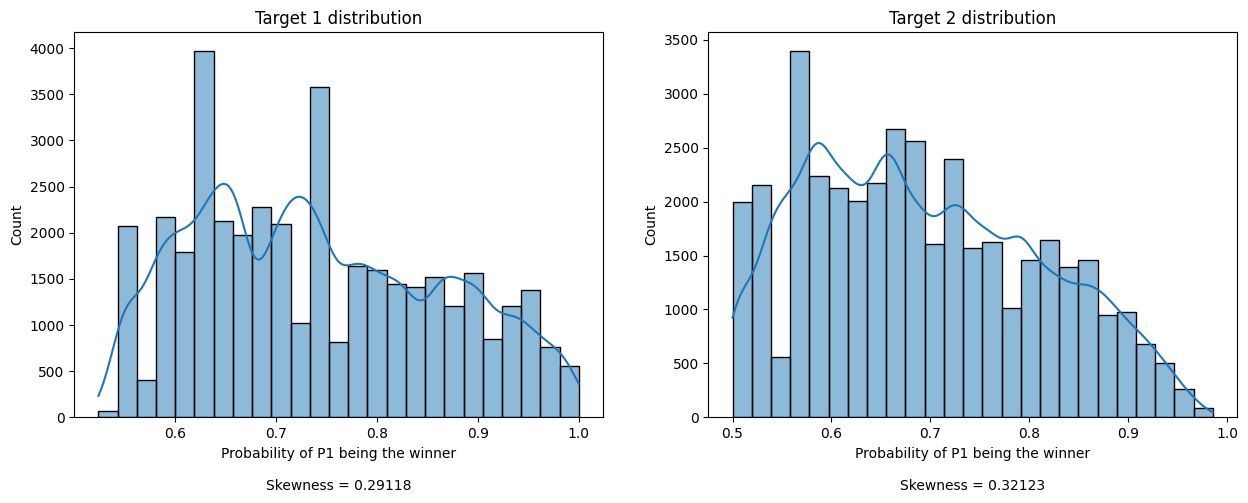

In [7]:
df['winner_is_p1'] = df.apply(build_features.winner_is_p1, axis=1)
df['odd_p1'] = df.apply(lambda row: row['b365w'] if row['winner_is_p1'] == 1 else row['b365l'], axis=1)
df['odd_p2'] = df.apply(lambda row: row['b365w'] if row['winner_is_p1'] == 0 else row['b365l'], axis=1)

df['target1'] = 1 / df['odd_p1']
df['target2'] = df['odd_p2'] / ( df['odd_p1'] + df['odd_p2'] )

fig, axs = plt.subplots(1, 2, figsize=(15,5))
for t in [1, 2]:
    # check if dataset if balanced
    sns.histplot(df[f'target{t}'], bins=25, alpha=0.5, kde=True, ax=axs[t-1])
    axs[t-1].set_xlabel(f'Probability of P1 being the winner\n\nSkewness = {round(skew(df[f'target{t}']),5)}')
    axs[t-1].set_title(f'Target {t} distribution')

df = df.drop('target2',axis=1)

Skewness: Measures the asymmetry of the distribution.

A skewness close to 0 indicates a symmetric distribution and a normally distributed target variable often leads to better model performance because many regression techniques assume normally distributed errors. 

Therefore, target will be ```P(P1wins) = 1 / odd_p1``` .

### Discovering patterns on betting odds 

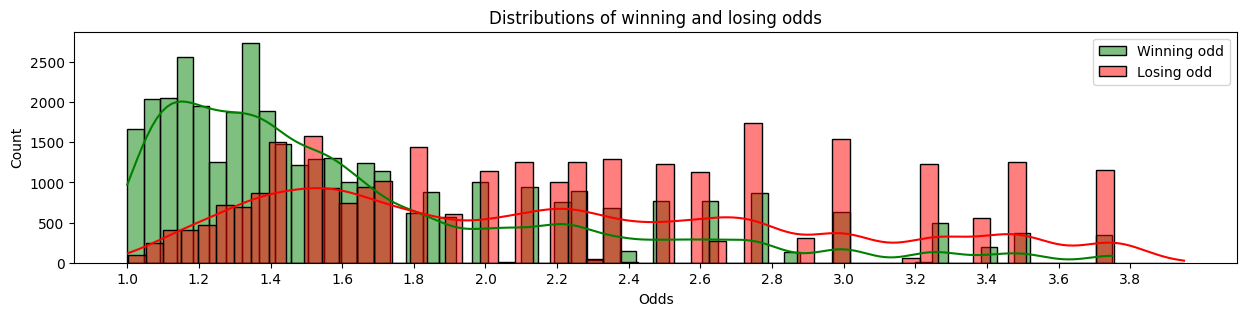

In [8]:
plt.figure(figsize=(15,3))

# use the 75th percentil of B365L to remove outliers
threshold = df.describe().loc["75%", "b365l"]

# create histogram for winning odds 
sns.histplot(df[df['b365w'] < threshold]['b365w'], bins=60, alpha=0.5, color='green', kde=True, label='Winning odd')

# create histogram for losing odds 
sns.histplot(df[df['b365l'] < threshold]['b365l'], bins=60, alpha=0.5, color='red', kde=True, label='Losing odd')

plt.xlabel('Odds')
plt.xticks(np.arange(1,4,0.2))
plt.title('Distributions of winning and losing odds')
plt.legend()
plt.show()

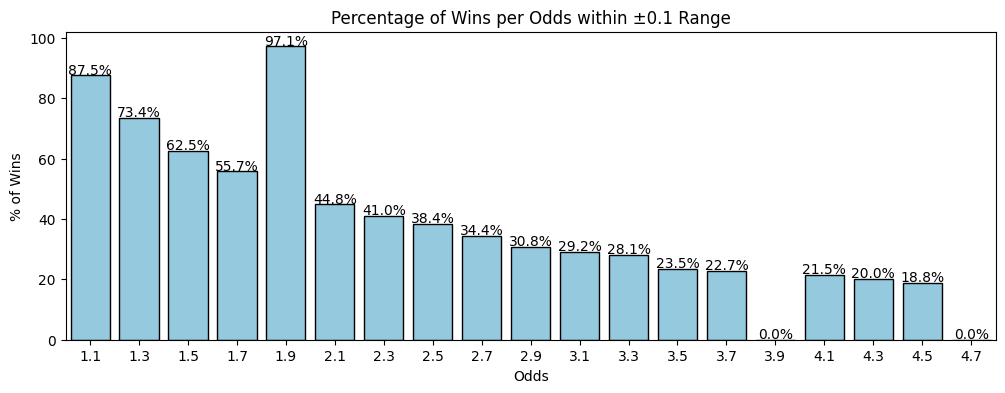

In [9]:
# Calculate the percentage of wins for each 0.05 interval
interval = 0.1
odds = np.arange(1.1 , 4.8 , 2 * interval)
win_percentages = []
total_odds = []

for i in odds:
    lower_bound, upper_bound = i - interval, i + interval
    wins_in_range = df[(df['b365w'] >= lower_bound) & (df['b365w'] < upper_bound)].shape[0]
    total_in_range = df[(df['b365w'] >= lower_bound) & (df['b365w'] < upper_bound) | (df['b365l'] >= lower_bound) & (df['b365l'] < upper_bound)].shape[0]
    win_percentages.append(wins_in_range / total_in_range * 100)
    total_odds.append(total_in_range)
    
plt.figure(figsize=(12,4))
sns.barplot(x=np.round(odds, 2), y=win_percentages, color='skyblue', edgecolor='black', dodge=False)
plt.xlabel('Odds')
plt.ylabel('% of Wins')
plt.title('Percentage of Wins per Odds within ±0.1 Range')
# Adding labeled values on top of each bar
for i in range(len(odds)):
    plt.text(i, np.round(win_percentages, 1)[i] + 0.5, str(np.round(win_percentages, 1)[i]) + '%', ha='center')
plt.show()

There's almost only wins between odds 1.8 and 2.0 because when both players have the same odd, those odds range from 1.8 to 2.0, as seen in the table below.

In [10]:
print('Equal Odds:')
df[df['b365w'] == df['b365l']][['b365w','b365l']].drop_duplicates()

Equal Odds:


,b365w,b365l
1732,1.833,1.833
3617,1.830,1.830
4493,1.909,1.909
15156,1.900,1.900


### Building features

 - <b>Rankings and Odds</b> - Both can be a valuable features but they have to be associated to the respective player (not the winner/loser.)
 - <b>Surface</b> - Since it is a categorical feature with no inherent ordering, One-Hot Encoding was used to represent each surface as a binary feature.
 - <b>Head-to-Head</b> - Records between two individual players.
 - <b>Number of consecutive wins and losses</b>
 - <b>Days since last win</b>

In [11]:
# save features list for analysis
features = []

# Ensure df is in chronological order
df = df.sort_values(by="date")

# Add match_id column
df['match_id'] = df.index

# Add rankings
df, features = build_features.add_ranks(df, features)

# Add the difference and ratio between players
df, features = build_features.add_rank_dif(df, features)
df, features = build_features.add_rank_ratio(df, features)

# Add the difference and ratio between players
df, features = build_features.add_odd_dif(df, features)
df, features = build_features.add_odd_ratio(df, features)

# Add a binary column for each surface
df, features = build_features.OHE_surface(df, features)

# Add consecutive wins or losses
df, features = build_features.add_consecutive_wins_and_losses(df, features)

# Add head-to-head
df, features = build_features.add_h2h(df, features)

{"time": "2024-07-04T19:03:51Z", "level": "INFO", "log": "Adding player's rankings..."}
{"time": "2024-07-04T19:03:53Z", "level": "INFO", "log": " -> Added player's rankings. (2.115092)"}
{"time": "2024-07-04T19:03:54Z", "level": "INFO", "log": "Adding ranking's differences..."}
{"time": "2024-07-04T19:03:55Z", "level": "INFO", "log": " -> Added ranking's differences. (1.003415)"}
{"time": "2024-07-04T19:03:56Z", "level": "INFO", "log": "Adding ranking's ratio..."}
{"time": "2024-07-04T19:03:57Z", "level": "INFO", "log": " -> Added ranking's ratio. (1.001917)"}
{"time": "2024-07-04T19:03:58Z", "level": "INFO", "log": "Adding odd's differences..."}
{"time": "2024-07-04T19:03:59Z", "level": "INFO", "log": " -> Added odd's differences. (1.004946)"}
{"time": "2024-07-04T19:04:00Z", "level": "INFO", "log": "Adding odd's ratio..."}
{"time": "2024-07-04T19:04:01Z", "level": "INFO", "log": " -> Added odd's ratio. (1.000786)"}
{"time": "2024-07-04T19:04:02Z", "level": "INFO", "log": "One-hot-en

In [12]:
# save data
df.to_csv(parent_dir + '/data/interim/features.csv')

In [13]:
df = data_utils.read_data(parent_dir + '/data/interim/')

{"time": "2024-07-04T19:05:22Z", "level": "INFO", "log": "Reading all files in tennis-predictor\\venv/data/interim/..."}
{"time": "2024-07-04T19:05:24Z", "level": "INFO", "log": "Shape of the dataset: (39497, 27)"}


In [14]:
features = SCHEMA['features'].keys()
eda_tools.check_missing_data(df[features])

No missing values.


### Discovering patterns on features

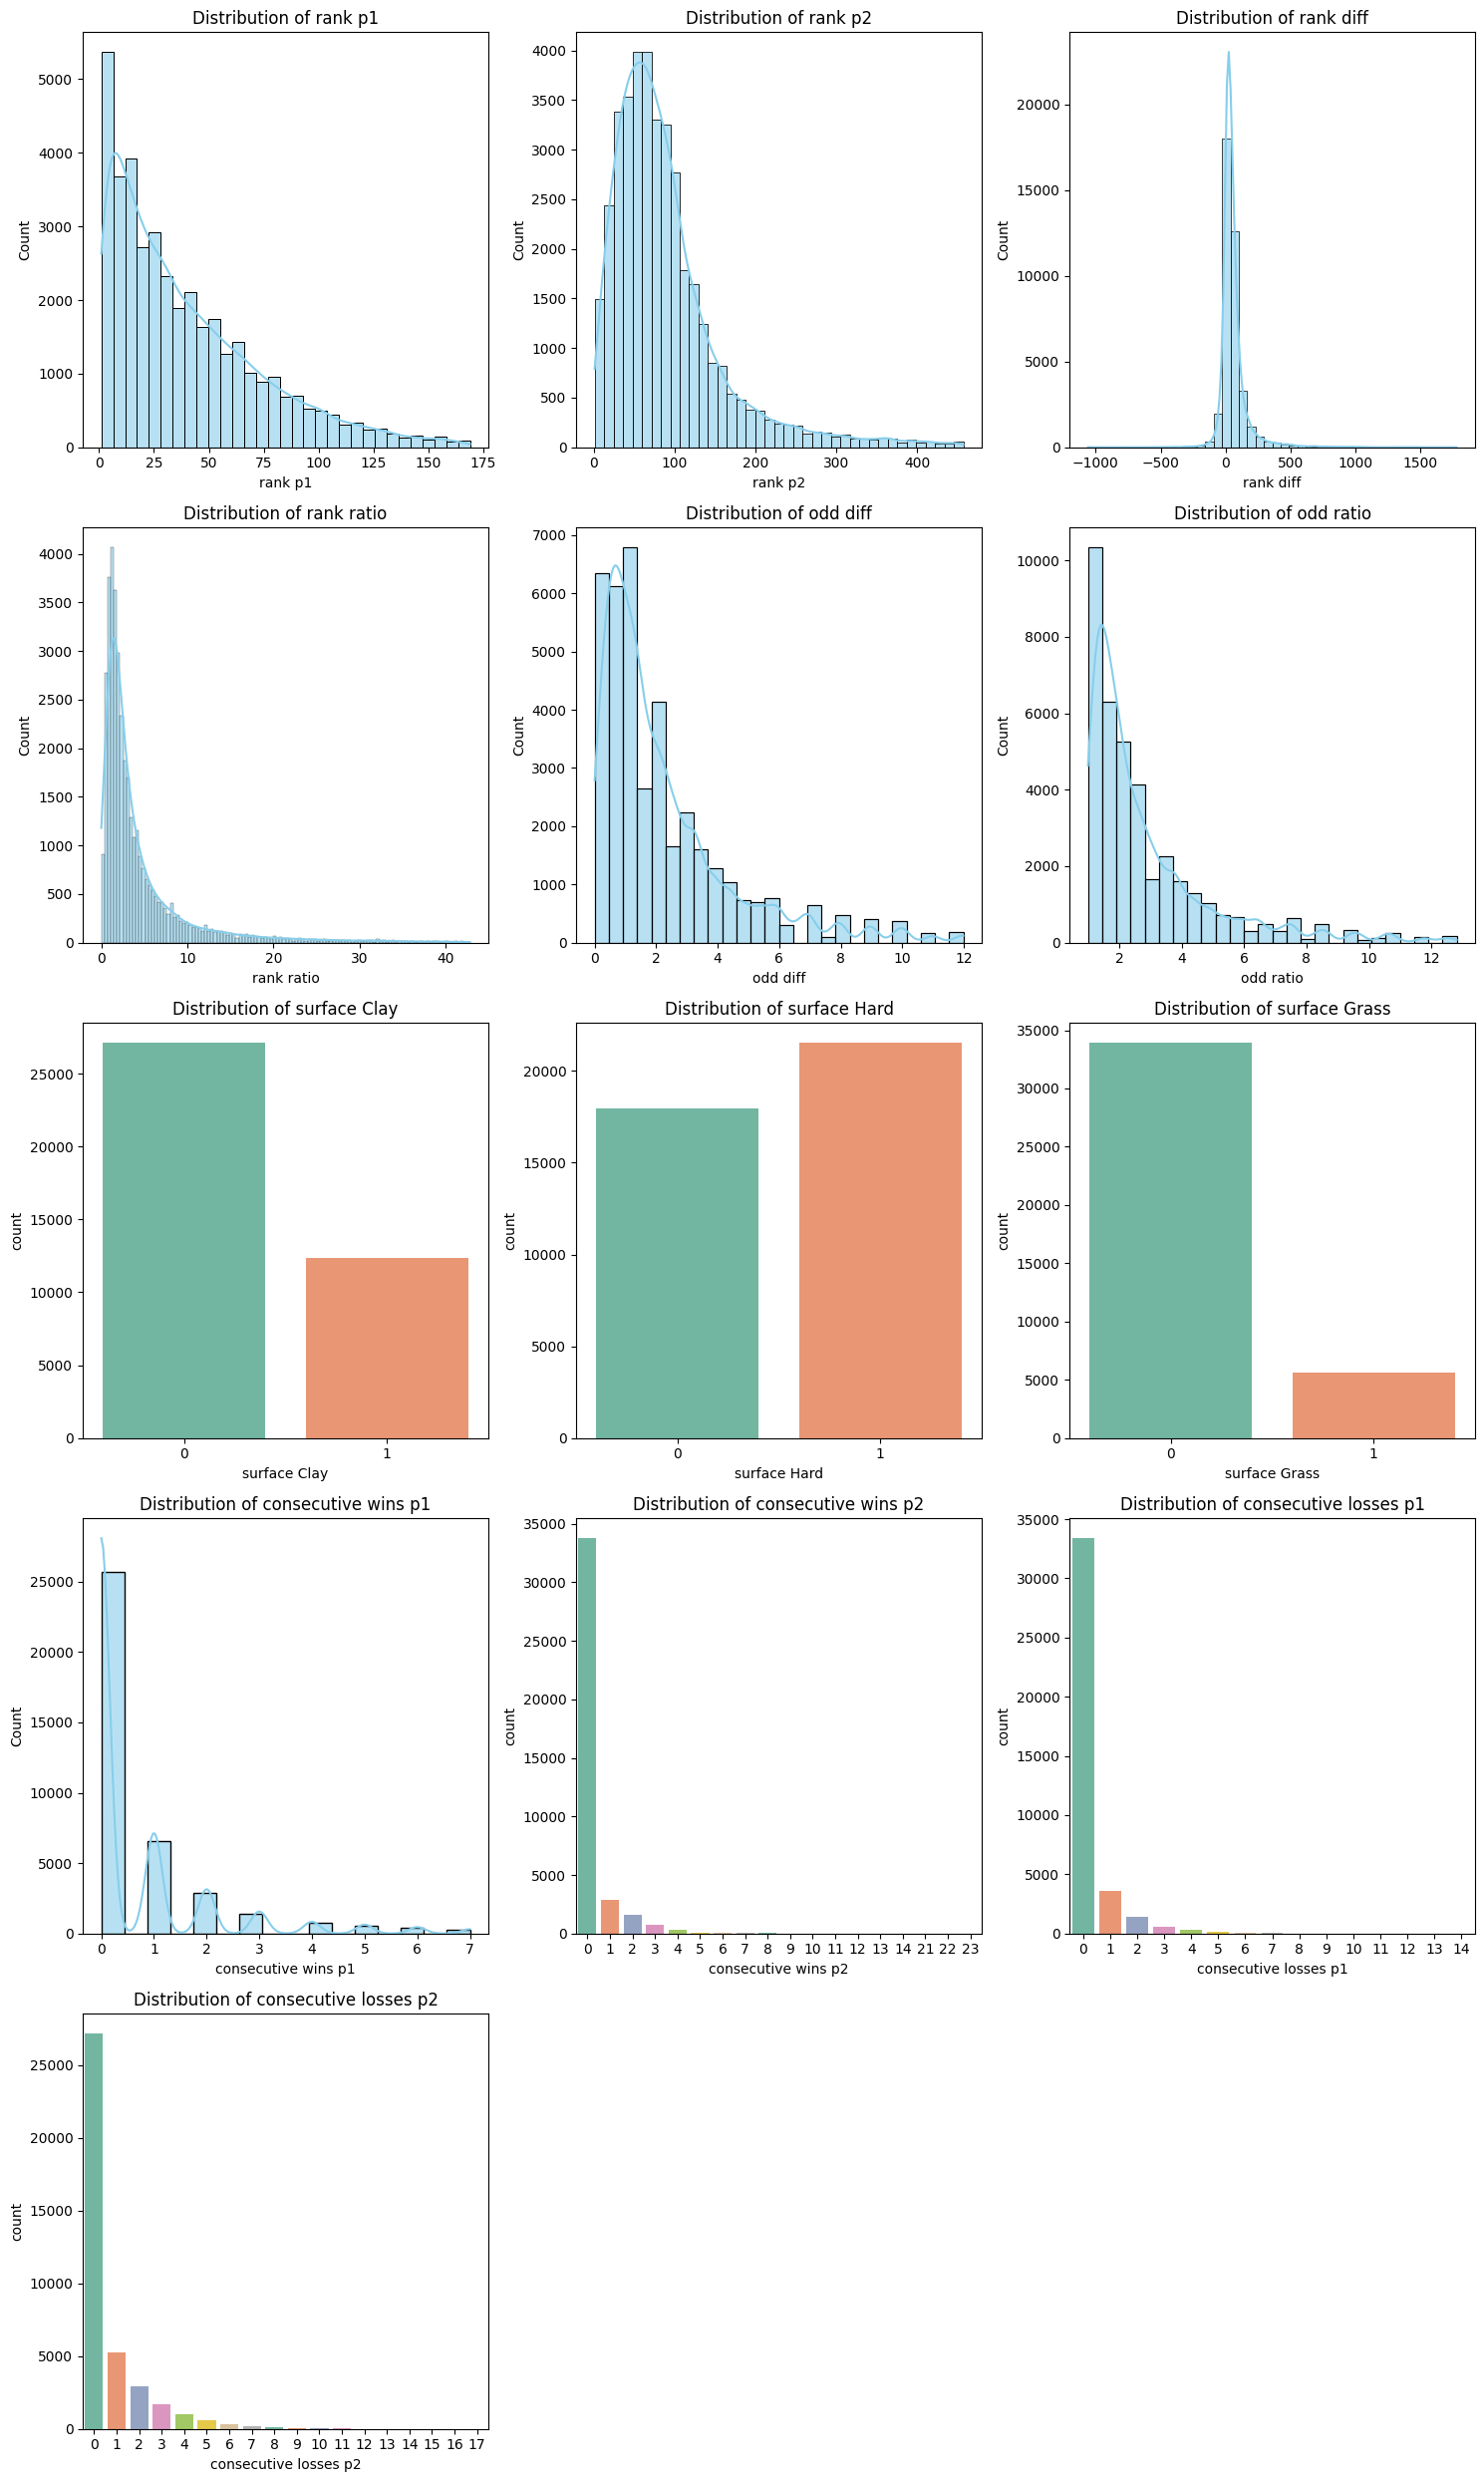

In [15]:
eda_tools.visualize_pd_series(df, features, skew_threshold=4, percentile_threshold=98)

### Outliers detection

In [16]:
df[features].describe()

,rank_p1,rank_p2,rank_diff,rank_ratio,odd_diff,odd_ratio,surface_Clay,surface_Hard,surface_Grass,consecutive_wins_p1,consecutive_wins_p2,consecutive_losses_p1,consecutive_losses_p2
count,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000,39497.000000
mean,44.644479,102.347469,57.702990,6.222811,2.571432,3.216957,0.313593,0.545155,0.141251,0.975669,0.278578,0.276122,0.748943
std,53.031801,117.403101,117.195092,17.971986,3.345435,3.315986,0.463959,0.497963,0.348285,2.393168,0.868796,0.832252,1.522338
min,1.000000,1.000000,-1059.000000,0.007782,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,45.000000,10.000000,1.307692,0.680000,1.433121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,74.000000,35.000000,2.431818,1.600000,2.142857,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,115.000000,74.000000,5.314815,3.130000,3.608333,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1093.000000,1855.000000,1778.000000,1370.000000,66.000000,67.000000,1.000000,1.000000,1.000000,38.000000,23.000000,14.000000,17.000000


We can see significant differences between <b>minimum/maximum values</b> and the respective <b>25th/75th percentil</b> and a high std in some columns, indicating the possibility of having outliers in columns:
- rank_p1,
- rank_p2,
- rank_diff and
- rank_ratio.

#### Rankings

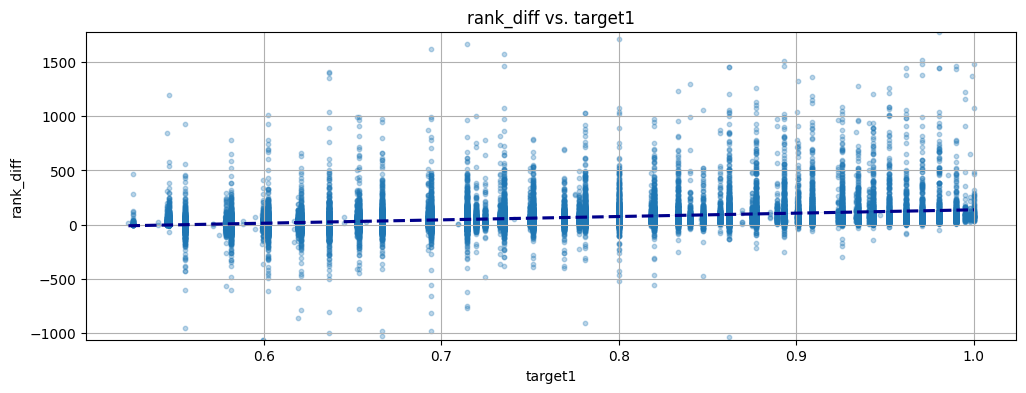

In [17]:
eda_tools.scatter(df, 'target1', 'rank_diff', func='linear_reg')

As expected, the probability of P1 winning tends to be higher when the difference in rankings between both players is higher.
Also, there might be some outliers in the area where the target is greater than 0.8 and rank_diff lower than -750
and where the target is lower than 0.8 and rank_diff greater than 1300. 

In [18]:
df[(df['target1'] > 0.8) & (df['rank_diff'] < -750)][features]

,rank_p1,rank_p2,rank_diff,rank_ratio,odd_diff,odd_ratio,surface_Clay,surface_Hard,surface_Grass,consecutive_wins_p1,consecutive_wins_p2,consecutive_losses_p1,consecutive_losses_p2
14357,1065,27,-1038,0.025352,3.34,3.87931,0,0,1,2,0,0,1


In [19]:
df[(df['target1'] < 0.8) & (df['rank_diff'] > 1300)][features]

,rank_p1,rank_p2,rank_diff,rank_ratio,odd_diff,odd_ratio,surface_Clay,surface_Hard,surface_Grass,consecutive_wins_p1,consecutive_wins_p2,consecutive_losses_p1,consecutive_losses_p2
11105,90,1554,1464,17.266667,1.51,2.110294,1,0,0,0,0,1,0
11504,77,1431,1354,18.584416,0.68,1.433121,0,1,0,0,0,0,0
12380,135,1533,1398,11.355556,0.68,1.433121,0,1,0,0,0,0,0
26742,94,1502,1408,15.978723,0.68,1.433121,0,1,0,0,0,0,11
34860,82,1751,1669,21.353659,1.35,1.964286,1,0,0,0,0,0,1
38922,113,1690,1577,14.955752,1.64,2.205882,0,1,0,0,0,0,6
39172,135,1753,1618,12.985185,1.18,1.819444,1,0,0,0,0,0,7


- Match no. 14357 will not be considered as an outlier because the target can be explained with the H2H feature.
- Matches no. 11504, 12380 and 34860 are considered as outliers because there are no feature that can explain the target for that differences in rankings. 
- Matches no. 26742, 38922 and 39172 are <b>not</b> considered as outliers because P1's coming for those matches in a sequence of 11, 6 and 7 consecutive losses, respectively.

## Features Correlation

Column pairs with correlation above 0.7
          level_0       level_1     0
16        rank_p2     rank_diff  True
29      rank_diff       rank_p2  True
61       odd_diff     odd_ratio  True
69       odd_diff       target1  True
74      odd_ratio      odd_diff  True
83      odd_ratio       target1  True
91   surface_Clay  surface_Hard  True
104  surface_Hard  surface_Clay  True
186       target1      odd_diff  True
187       target1     odd_ratio  True


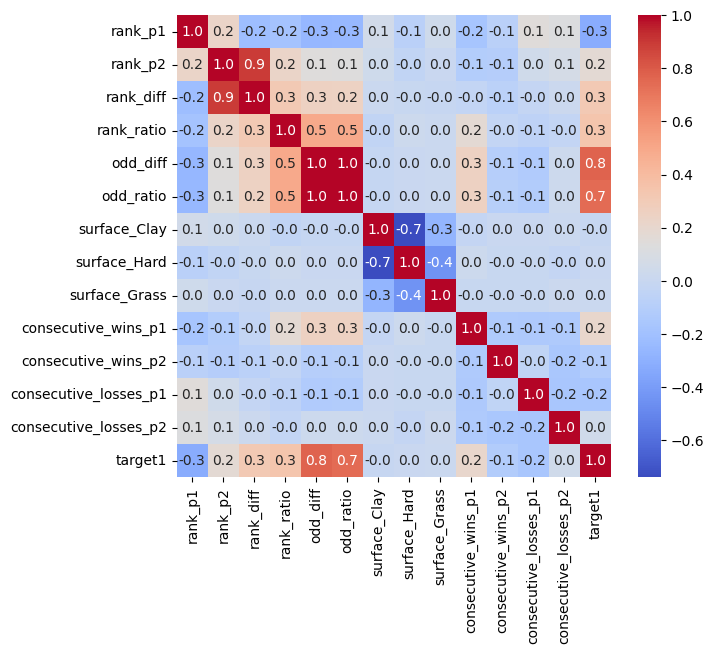

In [42]:
cols = list(features)
cols.append('target1')
correlation_matrix = df[cols].corr()
threshold = 0.7

# Display column names where correlation exceeds the threshold
high_correlation_columns = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)
correlated_columns = high_correlation_columns.unstack().reset_index()
correlated_columns = correlated_columns[correlated_columns[0]].rename_axis(None, axis=1)
if correlated_columns.empty:
    print('There are no correlated features.')
else:
    print("Column pairs with correlation above", threshold)
    print(correlated_columns)

# Config figure size
plt.figure(figsize=(7,6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")

# Display the plot
plt.show()

In [ ]:
def plot_percentage_of_winner_is_p1(feature, bins, labels=True):
    """ 
    Args:
        feature (str)
    """
   # Group by the bins and calculate the percentage of winner_is_p1
    df[f'{feature}_bin'] = pd.cut(df[feature], bins=bins)
    grouped = df.groupby(f'{feature}_bin')['winner_is_p1'].mean() * 100

    # Plot the bar chart
    grouped.plot(kind='bar')
    plt.xlabel(feature)
    plt.ylabel('% of P1 being the winner')
    plt.title(f'% of P1 being the winner based on {feature}')
    # Add labels to each bar
    if labels==True:
        for i, val in enumerate(grouped):
            plt.text(i, val + 1, f'{val:.2f}%', ha='center')
    

features_to_plot = {
    'OddP1': np.arange(1.0,3.0,0.2),
    'OddP2': np.arange(1.0,3.0,0.2),
    'RankP1': np.arange(1,150,10),
    'RankP2':  np.arange(1,150,10),
    'Rank_dif': np.arange(1,100,10),
}

#for feature, bin in features_to_plot.items():
#    plot_percentage_of_winner_is_p1(feature, bin)
plot_percentage_of_winner_is_p1('Rank_dif', np.arange(1,200,15), labels=False)